<h2 style="padding:30px; font-weight:600; color:blue; text-align:center; font-size:3em">Analyse des livres les mieux notés sur Twitter.</h2>
<hr>

<h2 style="text-decoration:underline; margin-bottom:20px" >Import et chargements des données</h2>

In [1]:
import pandas as pd
from pandas.errors import ParserError
import re
import string
import os
from nltk.corpus import stopwords
from nltk import word_tokenize
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.image import imread
import numpy as np
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from nltk.collocations import BigramAssocMeasures, BigramCollocationFinder
from nltk.collocations import TrigramAssocMeasures, TrigramCollocationFinder
import demoji


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\utilisateur\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
path = "../data/Twitter/"
files = os.listdir(path)
df_list = []
file_names = []

for file_name in files :
    text = re.sub('.csv', '', file_name)
    text = re.sub('_', ' ', text)
    try :
        df = pd.read_csv( path + file_name, delimiter='|')
        file_names.append(text)
        df.name = text
        df_list.append(df)  
    except ParserError as e:
        print(f" ⚠️ ParserError for {file_name} : {e}" )
        print("CSV non conforme, veuillez supprimer ou corriger les lignes mentionnées\n")
        
print(f"{len(df_list)} dataframes ont été créé sur {len(files)} possibles .")

5 dataframes ont été créé sur 5 possibles .


<h2 style="text-decoration:underline; margin-bottom:20px" >Nettoyage des données</h2>

In [3]:
for df in df_list:
    print(" ========= " + df.name.upper() + " ============= ")
    print(df.isna().sum())
    print('')

 ========= BATMAN ============= 
id                   0
url                  0
date                 0
renderedContent      0
hashtags           825
replyCount           0
retweetCount         0
likeCount            0
dtype: int64

 ========= THE ART OF WAR ============= 
,tweets,,,,,,,,    0
dtype: int64

 ========= THE BOOK THIEF ============= 
,tweets;;;;    0
dtype: int64

 ========= THE PICTURE OF DORIAN GREY ============= 
,tweets;;    0
dtype: int64

 ========= THE SONG OF ACHILLES ============= 
,tweets;;;;;;;    0
dtype: int64



In [4]:
df_list[0].rename(columns={'renderedContent':'tweets'}, inplace=True)
df_list[1].rename(columns={',tweets,,,,,,,,':'tweets'}, inplace=True)
df_list[2].rename(columns={',tweets;;;;':'tweets'}, inplace=True)
df_list[3].rename(columns={',tweets;;':'tweets'}, inplace=True)
df_list[4].rename(columns={',tweets;;;;;;;':'tweets'}, inplace=True)

<h2 style="text-decoration:underline; margin-bottom:20px">Fonctions de traitement du texte et d'affichage des résultats</h2>

In [9]:
# Nettoyage du texte

def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation, multiples spaces, quotations 
    marks and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"\s+", " ", text)  # Remove multiple spaces in content
    text = text.replace("‘","").replace("’", "").replace('“', '').replace('”','')  # Remove quotations marks
    return text

def remove_stopwords(text, more_stopwords):
    stop_words = set(stopwords.words('english') + more_stopwords)    
    # Remove stop stopwords
    text = ' '.join(word for word in text.split(' ') if word not in stop_words)
    # Remove one letters words
    text = ' '.join(word for word in text.split(' ') if len(word) > 1)
    return text

def replace_emojis(text):
    text = demoji.replace_with_desc(text)
    text = re.sub(':', '', text)
    return text

def complete_cleaning(text, more_stopwords):
    cleaned_text = clean_text(text)
    cleaned_text = remove_stopwords(cleaned_text, more_stopwords)
    cleaned_text = replace_emojis(cleaned_text)
    return cleaned_text

In [10]:
# Affichage des résultats

def display_wordcloud(text, title, max_words=50 ):    
    wc = WordCloud(
        background_color='white', 
        max_words=max_words, 
        colormap="viridis",
        mask = imread("twitter_mask.webp"),
        collocations=False
    )
    wc.generate(text)
    plt.figure(figsize=(12,8))
    plt.title(f'Top words for {title}', 
              fontdict={'size': 18,  'verticalalignment': 'bottom', 'fontweight':'bold'})
    plt.imshow(wc)
    plt.axis("off")
    plt.show()
    
def display_2grams_frequencies(text, title):
    tokens = nltk.word_tokenize(text) 
    bigram_finder = BigramCollocationFinder.from_words(tokens)
    bigram_freq = bigram_finder.ngram_fd.items()
    top_bigrams = sorted(bigram_freq, key=lambda item: item[1], reverse=True)[:20]
    x_values = [bigram[0][0] + " " + bigram[0][1] for bigram in top_bigrams]
    y_values = [bigram[1] for bigram in top_bigrams]
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values)
    plt.title(f"Top 20 Bigrams for {title}")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel("Frequency")
    plt.show()
        
def display_3grams_frequencies(text, title):
    tokens = nltk.word_tokenize(text)
    trigram_finder = TrigramCollocationFinder.from_words(tokens)
    trigram_freq = trigram_finder.ngram_fd.items()
    top_trigrams = sorted(trigram_freq, key=lambda item: item[1], reverse=True)[:20]
    x_values = [trigram[0][0] + " " + trigram[0][1] + " " + trigram[0][2] for trigram in top_trigrams]
    y_values = [trigram[1] for trigram in top_trigrams]
    plt.figure(figsize=(10, 6))
    plt.bar(x_values, y_values)
    plt.title(f"Top 20 Trigrams for {title}")
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('')
    plt.ylabel("Frequency")
    plt.show()
        
def display_sentiment_analysis(text, title):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    labels = ['Negative', 'Neutral', 'Positive']
    sizes = [scores['neg'], scores['neu'], scores['pos']]
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.pie(sizes, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')
    ax.set_title(f"Sentiment Analysis for {title}", fontsize=25, weight='bold')
    ax.legend(labels, loc='best', fontsize=14)
    plt.show()
    print('')
    for key, val in scores.items():
        print(key, val, sep=' - ')
    
def words_analysis(data : pd.Series, book_title : string, more_stopwords = None):    
    # stack in one string
    full_text = ' '.join(data)
    # clean the text
    cleaned_text = complete_cleaning(full_text, more_stopwords)    
    # display wordcloud 1-gram
    display_wordcloud(cleaned_text, book_title)
    display_2grams_frequencies(cleaned_text, book_title)
    print("")
    display_3grams_frequencies(cleaned_text, book_title)
    print("")
    display_sentiment_analysis(cleaned_text, book_title)

<h2 style="margin-bottom:20px; font-weight:800; color:blue; text-align:center; font-size:2.5em">Analyse des tweets</h2>

In [11]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

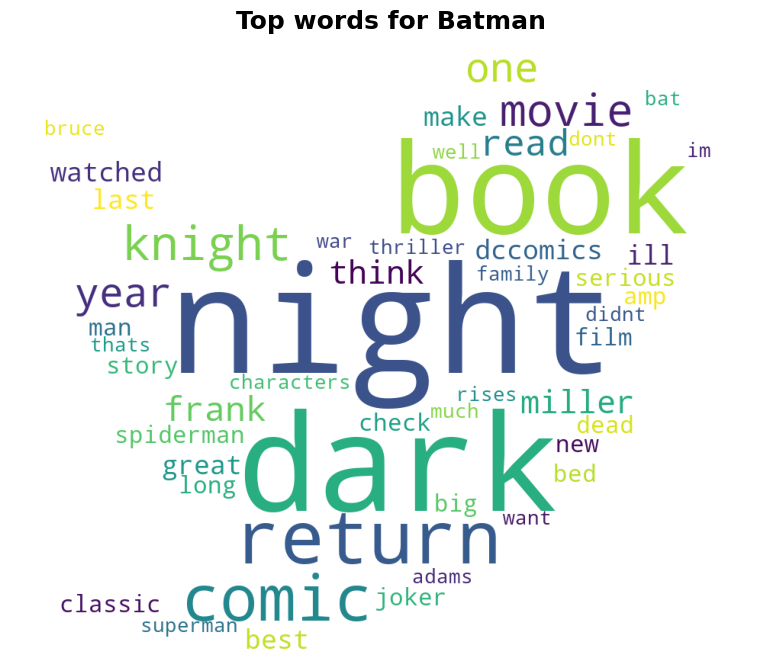

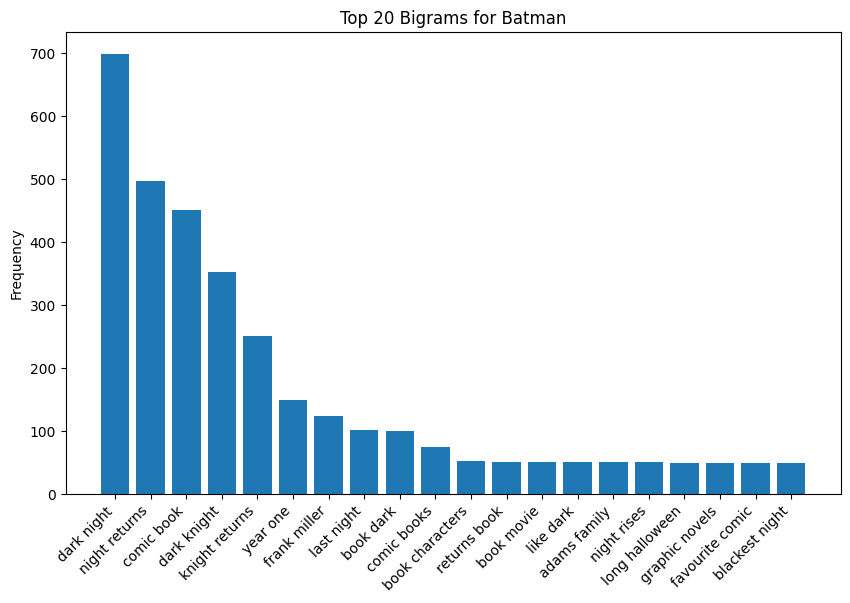

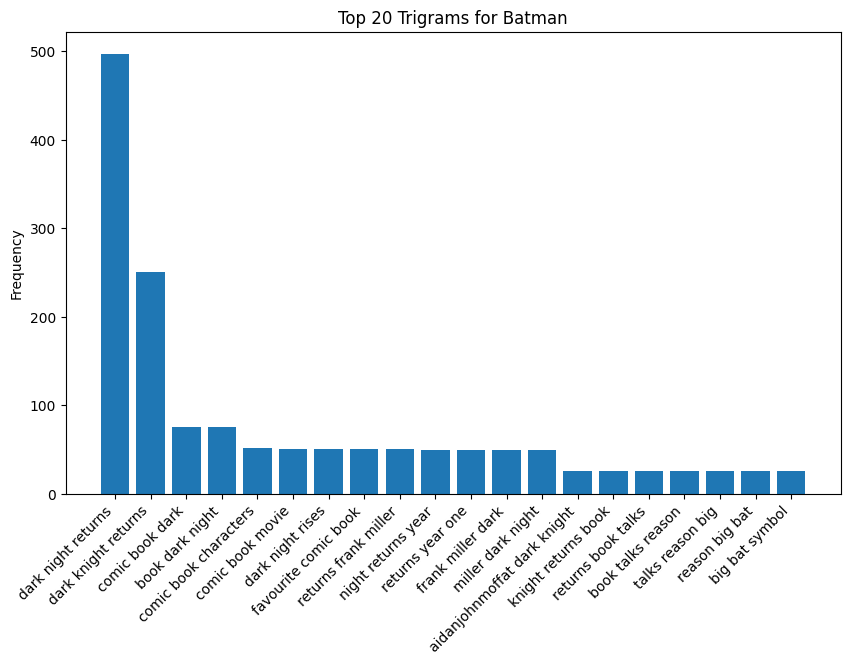

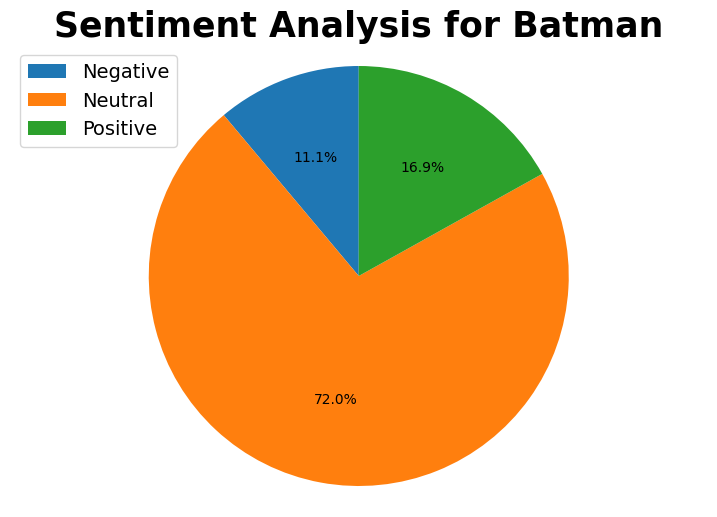


neg - 0.111
neu - 0.719
pos - 0.169
compound - 1.0


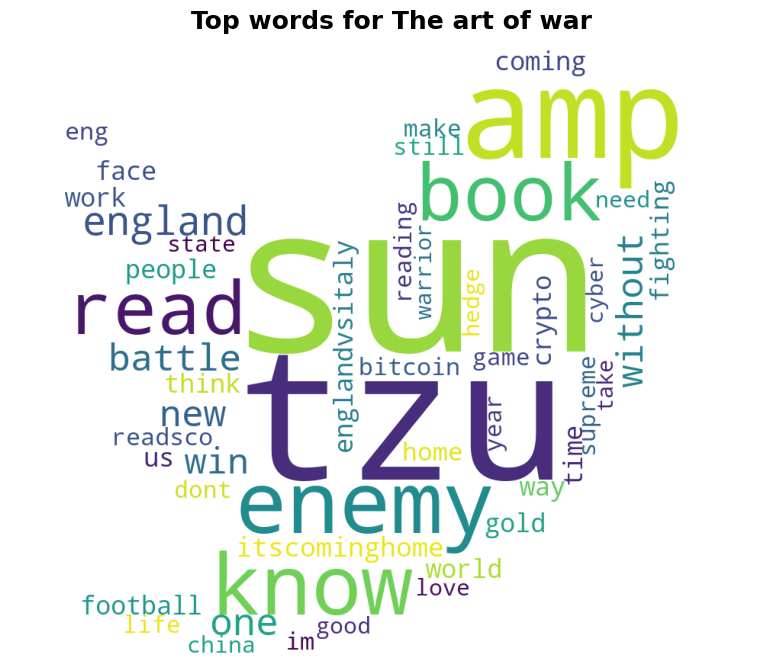

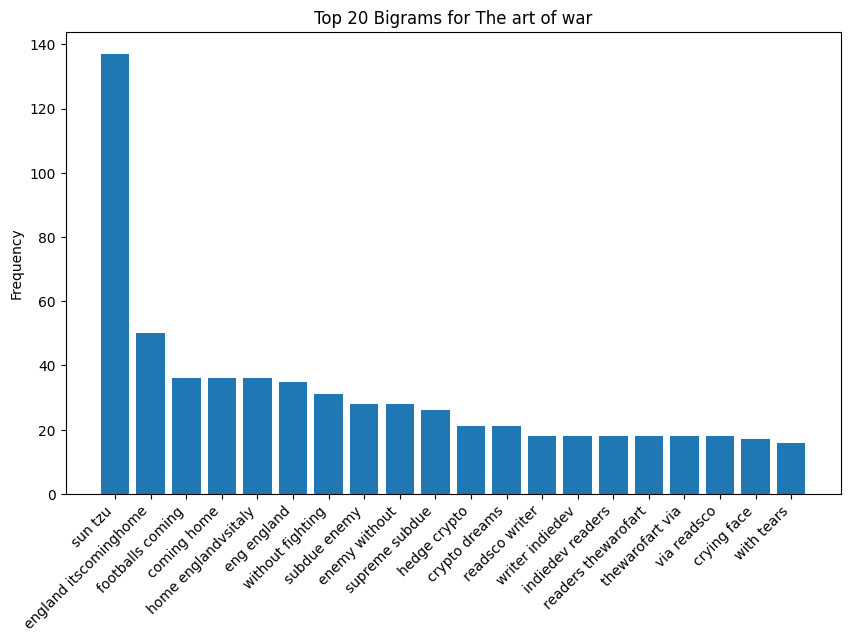

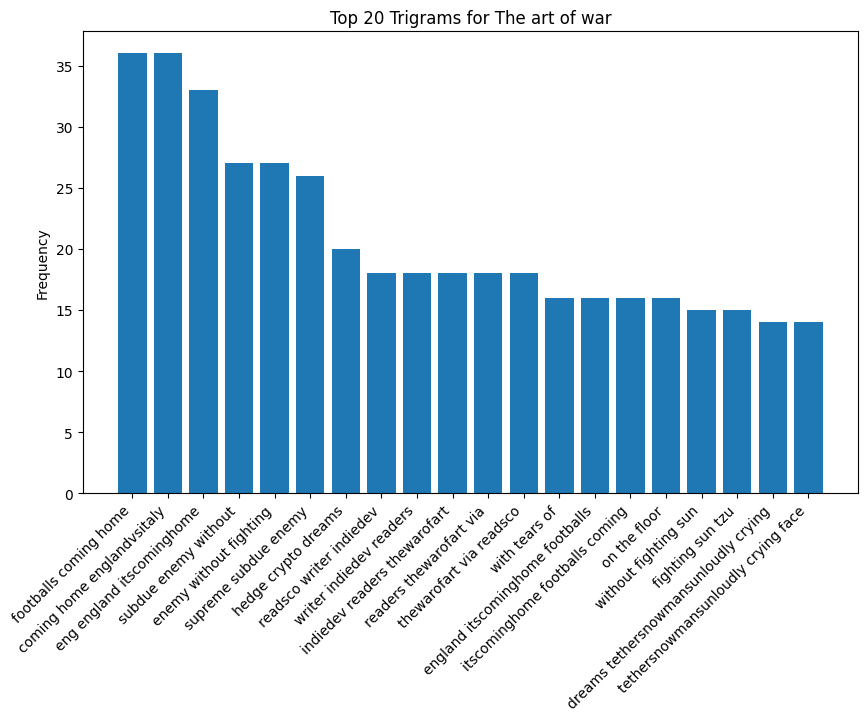

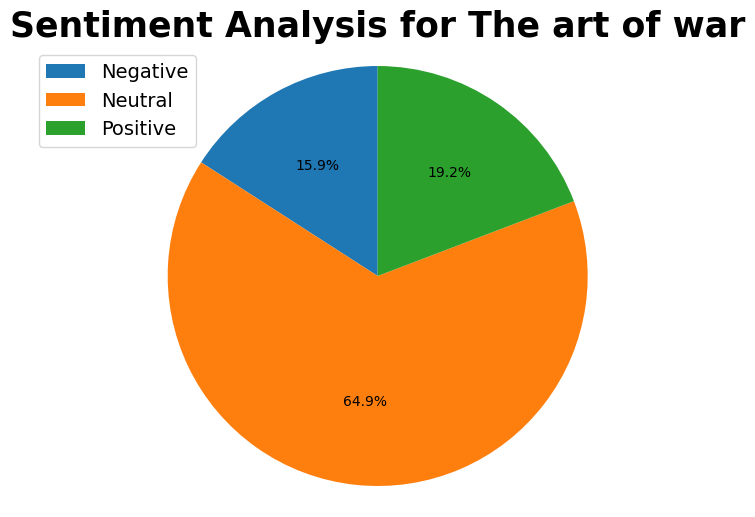


neg - 0.159
neu - 0.649
pos - 0.192
compound - 1.0


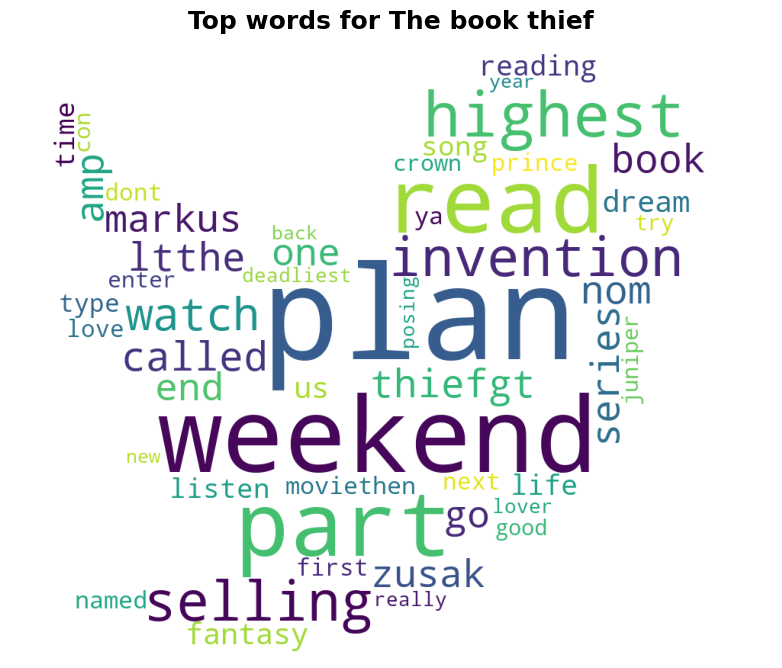

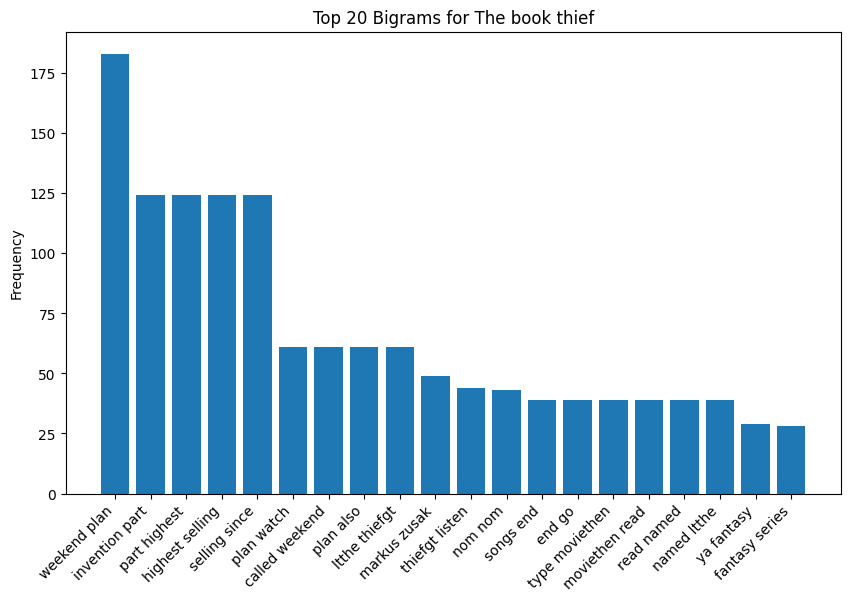

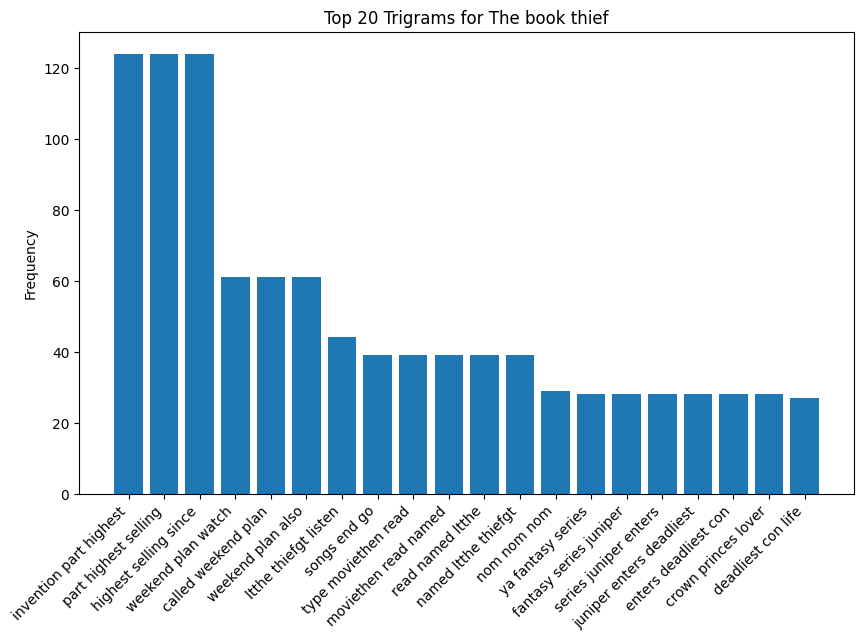

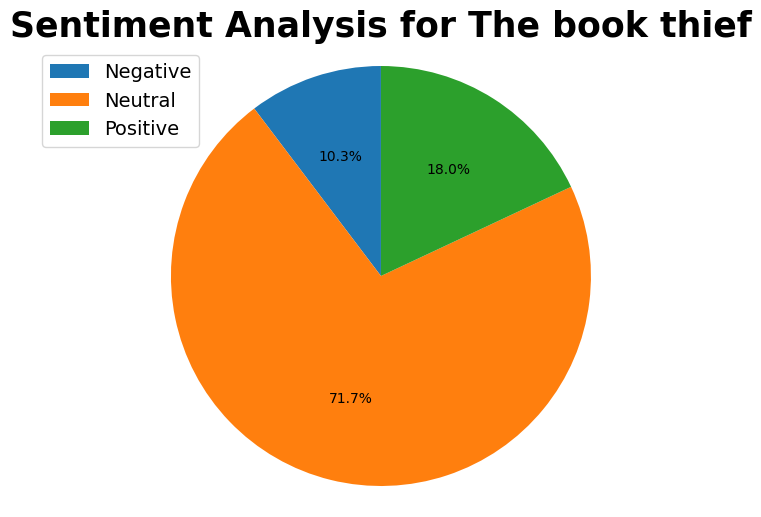


neg - 0.103
neu - 0.716
pos - 0.18
compound - 1.0


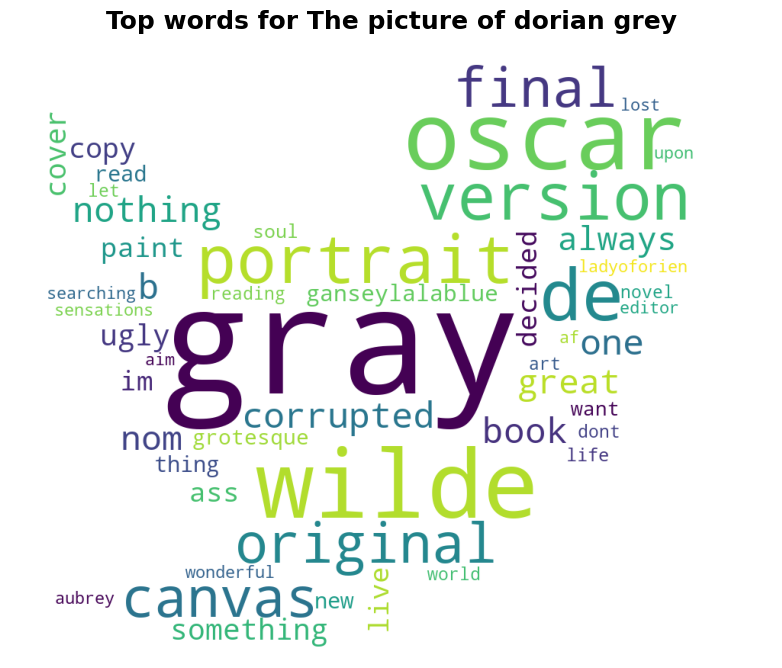

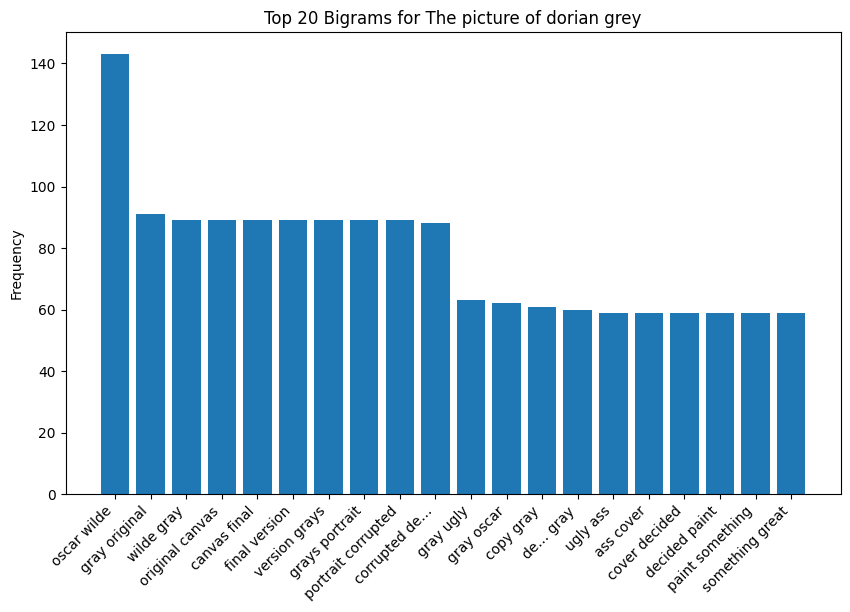

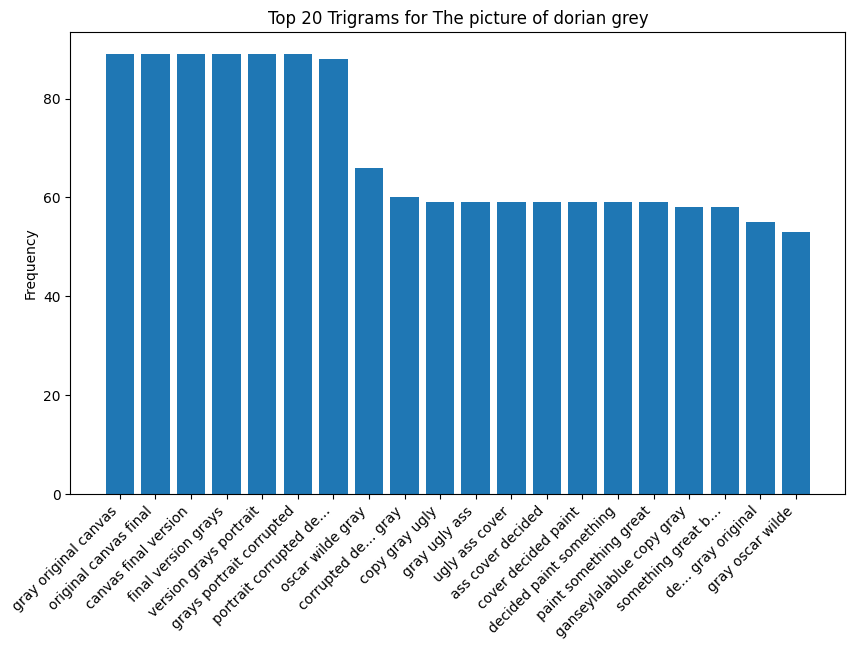

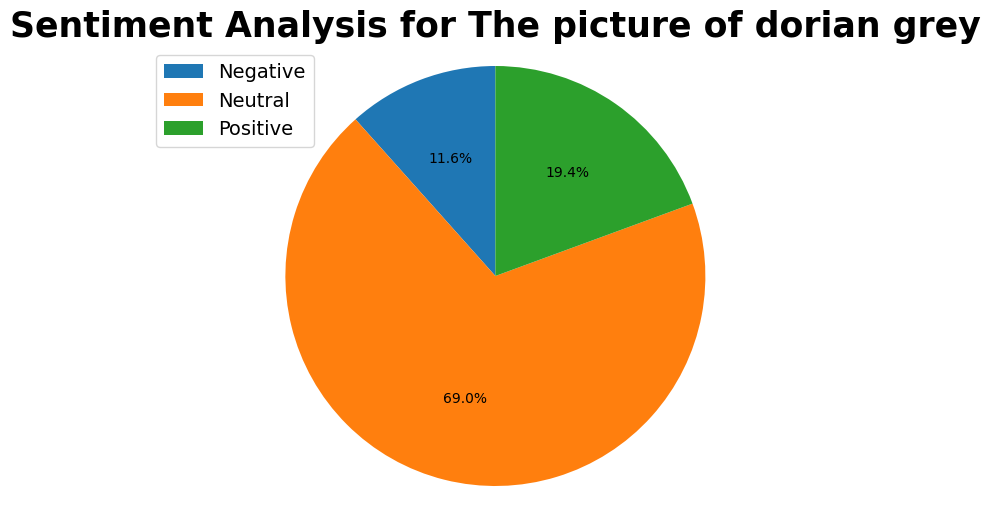


neg - 0.116
neu - 0.69
pos - 0.194
compound - 1.0


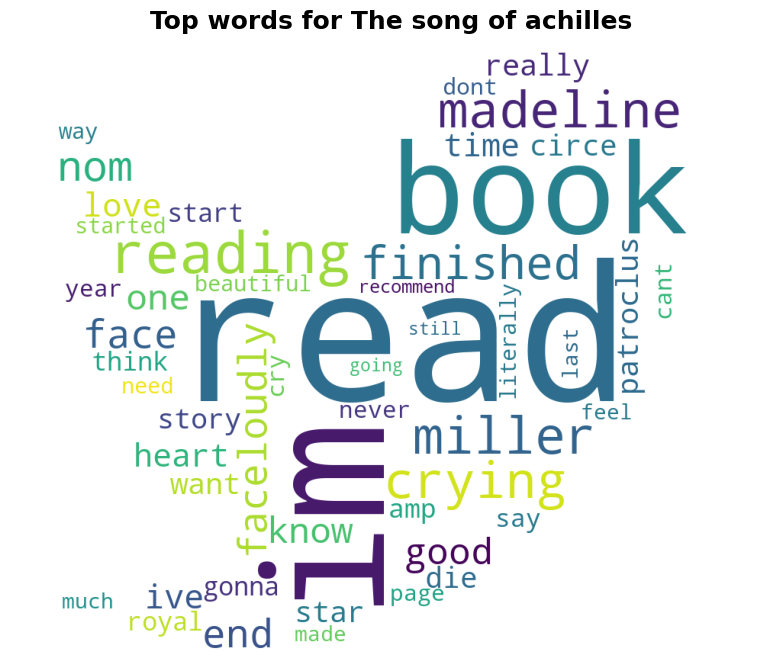

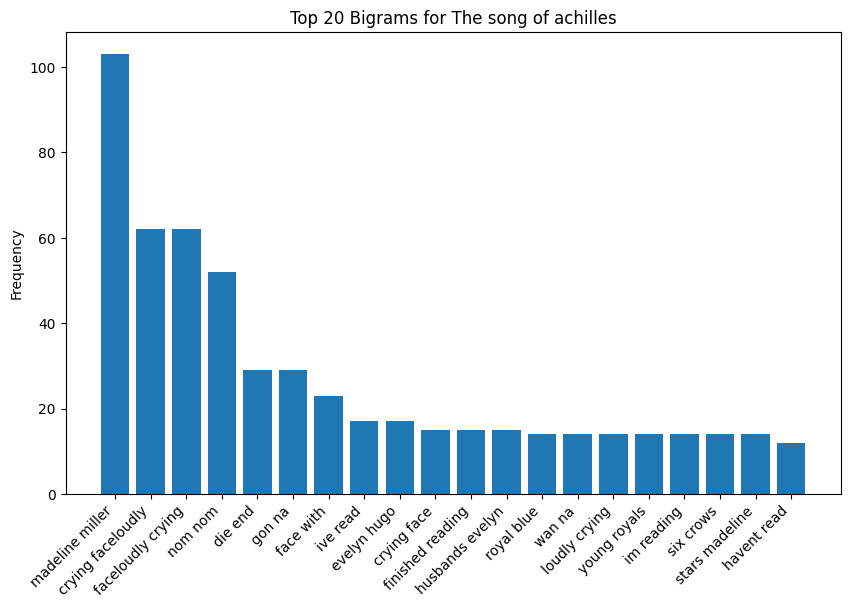

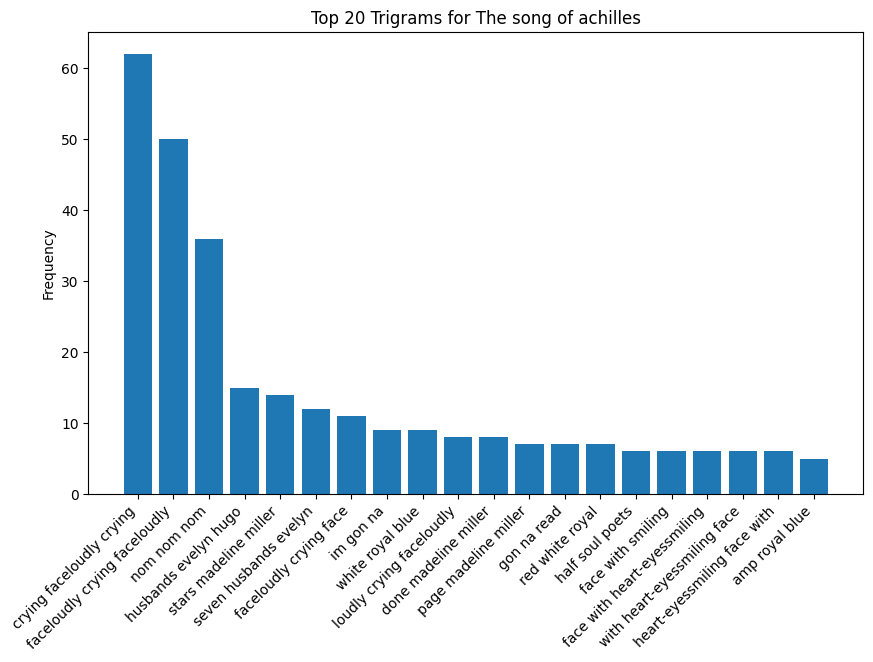

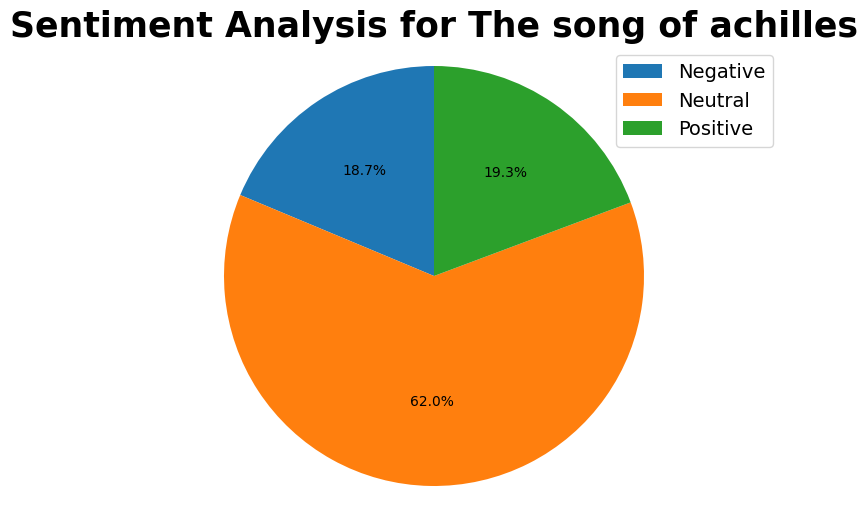


neg - 0.187
neu - 0.62
pos - 0.193
compound - 0.8152


In [12]:
for df in df_list:
    # Remove words from book titles for the analysis
    more_stopwords = df.name.split()
    words_analysis(data = df['tweets'], book_title = df.name.capitalize(), more_stopwords = more_stopwords)